# Introduction to Convolutional Neural Networks (CNNs)

## Session 2: Understanding the Building Blocks of Computer Vision

Welcome to the exciting world of Convolutional Neural Networks!

Author: [Parham Kebria, PhD](https://parhamkebria.com)

### In this session, we'll explore:

1. **Why CNNs for Images?** - The fundamental motivation
2. **Convolution Operation** - The core mathematical concept
3. **Filters/Kernels** - Feature detection in action
4. **CNN Building Blocks** - Convolution, Pooling, Activation
5. **Edge Detection** - Visual demonstrations
6. **Feature Hierarchies** - From edges to objects
7. **CNN Architecture** - Putting it all together
8. **PyTorch Implementation** - Building your first CNN

### By the end of this session, you'll understand:

- Why classical ML fails at spatial understanding
- How convolution operations work mathematically and visually
- The role of filters in feature detection
- How CNNs build hierarchical representations
- Implementation of CNNs in PyTorch

### Let's dive into the world of spatial intelligence!


## 📄 Copyright & License Notice

**© 2025 Parham Kebria. All Rights Reserved.**

This notebook is protected by copyright law. Unauthorized reproduction, distribution, modification, or commercial use is strictly prohibited without written permission from the author.

**Permitted Use:**

- Personal learning and education
- Academic research (with proper citation)
- Classroom instruction (with attribution)

**Prohibited Use:**

- Commercial redistribution
- Modification without permission
- Removal of copyright notices
- Claiming authorship

**Citation Required:** When referencing this work, please cite:

```
Kebria, P. (2025). Deep Learning for Image Classification.
```

**Contact:** For licensing inquiries, contact [Parham Kebria](https://parhamkebria.com)

---


## 1. Import Required Libraries

Let's start by importing all the essential libraries for our CNN exploration.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage
from sklearn.datasets import fetch_openml
import warnings
warnings.filterwarnings('ignore')

# Matplotlib settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

All libraries imported successfully!
PyTorch version: 2.2.2
Device available: CPU


## 2. Why CNNs for Images? The Problem with Fully Connected Networks

Before diving into CNNs, let's understand why traditional fully connected networks struggle with images. We'll use a simple example to demonstrate the spatial limitations we discovered in Session 1.


Original label: 5


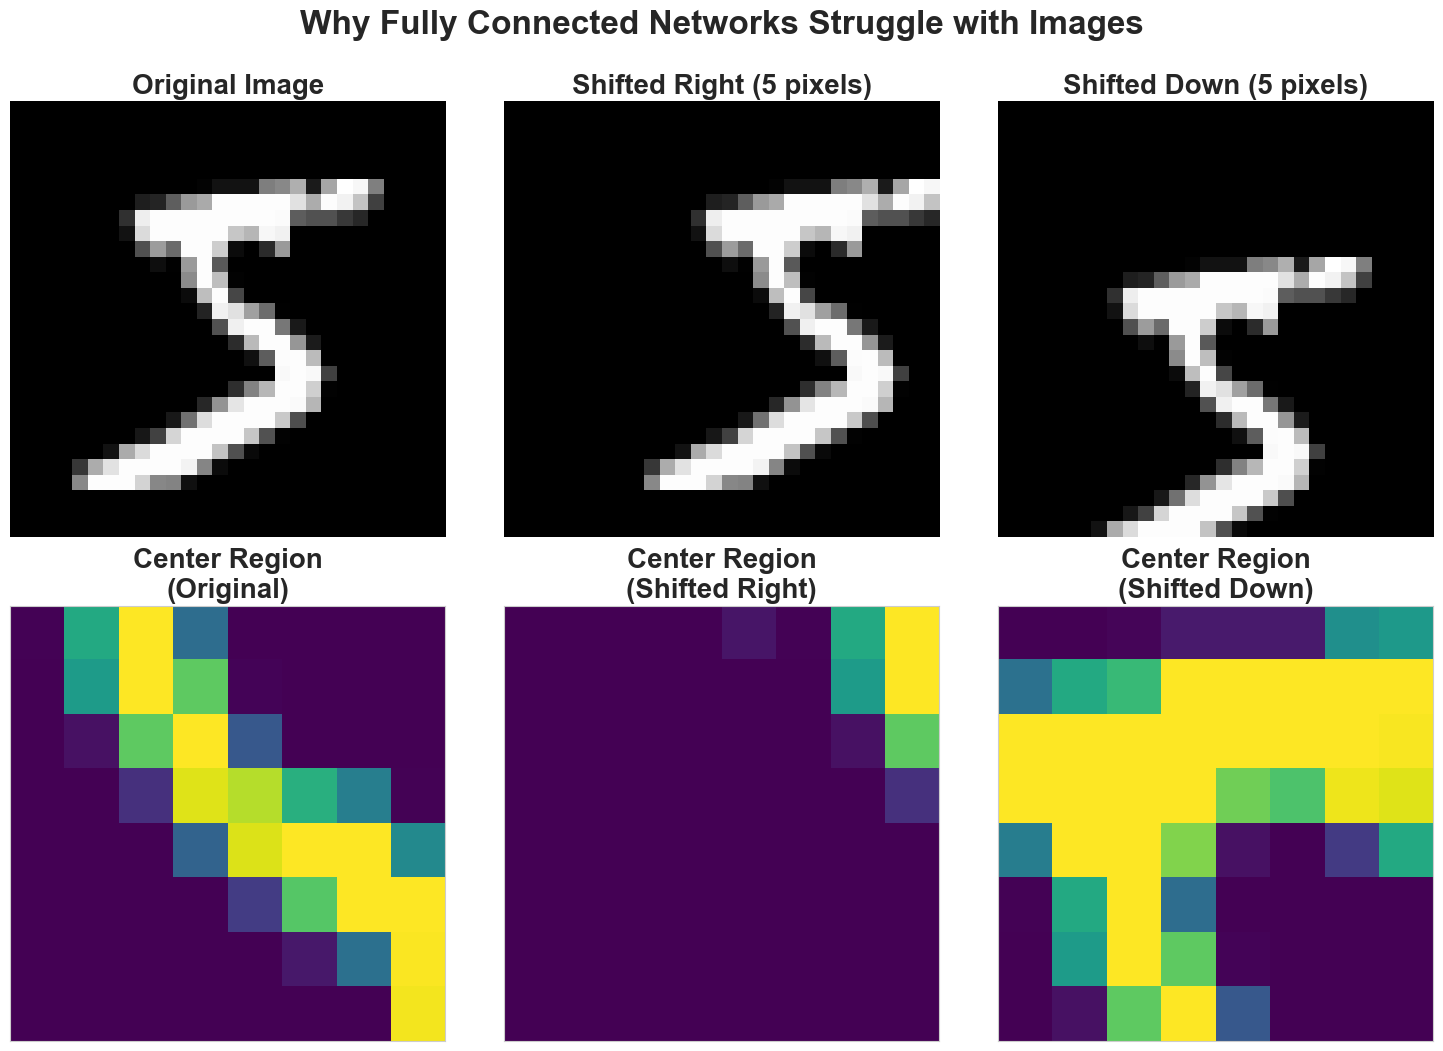


Pixel differences:
Original vs Shifted Right: 154.48
Original vs Shifted Down: 170.62

To a fully connected network, these are completely different inputs!
But humans recognize all three as the same digit.


In [2]:
# Load MNIST data
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X, y = mnist.data, mnist.target.astype(int)

# Normalize to [0, 1]
X = X / 255.0

# Get a sample image
sample_idx = 0
original_image = X[sample_idx].reshape(28, 28)
original_label = y[sample_idx]

print(f"Original label: {original_label}")

# Create shifted versions
shift_right = ndimage.shift(original_image, [0, 5], cval=0)
shift_down = ndimage.shift(original_image, [5, 0], cval=0)

# Visualize the spatial problem
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# First row: Images
axes[0, 0].imshow(original_image, cmap='gray')
axes[0, 0].set_title('Original Image', fontsize=20, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(shift_right, cmap='gray')
axes[0, 1].set_title('Shifted Right (5 pixels)', fontsize=20, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(shift_down, cmap='gray')
axes[0, 2].set_title('Shifted Down (5 pixels)', fontsize=20, fontweight='bold')
axes[0, 2].axis('off')

# Second row: Pixel difference heatmaps (center 8x8 region for clarity)
center_orig = original_image[10:18, 10:18]
center_right = shift_right[10:18, 10:18]
center_down = shift_down[10:18, 10:18]

im1 = axes[1, 0].imshow(center_orig, cmap='viridis', interpolation='nearest')
axes[1, 0].set_title('Center Region\n(Original)', fontsize=20, fontweight='bold')
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])

im2 = axes[1, 1].imshow(center_right, cmap='viridis', interpolation='nearest')
axes[1, 1].set_title('Center Region\n(Shifted Right)', fontsize=20, fontweight='bold')
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])

im3 = axes[1, 2].imshow(center_down, cmap='viridis', interpolation='nearest')
axes[1, 2].set_title('Center Region\n(Shifted Down)', fontsize=20, fontweight='bold')
axes[1, 2].set_xticks([])
axes[1, 2].set_yticks([])

plt.tight_layout()
plt.suptitle('Why Fully Connected Networks Struggle with Images', fontsize=24, fontweight='bold', y=1.05)
plt.show()

# Calculate pixel differences
diff_right = np.abs(original_image.flatten() - shift_right.flatten()).sum()
diff_down = np.abs(original_image.flatten() - shift_down.flatten()).sum()

print(f"\nPixel differences:")
print(f"Original vs Shifted Right: {diff_right:.2f}")
print(f"Original vs Shifted Down: {diff_down:.2f}")
print(f"\nTo a fully connected network, these are completely different inputs!")
print("But humans recognize all three as the same digit.")

## 3. Enter Convolutional Neural Networks: The Solution

CNNs solve these problems through three key innovations:

1. **Local Connectivity**: Instead of connecting every pixel to every neuron, CNNs use small filters that look at local regions
2. **Parameter Sharing**: The same filter is applied across the entire image
3. **Translation Invariance**: Features can be detected regardless of their position in the image

Let's explore these concepts step by step!


### 3.1 Understanding Convolution: Filters and Kernels

A **filter** (or **kernel**) is a small matrix that slides across the input image to detect specific features. Let's create and visualize different types of filters.


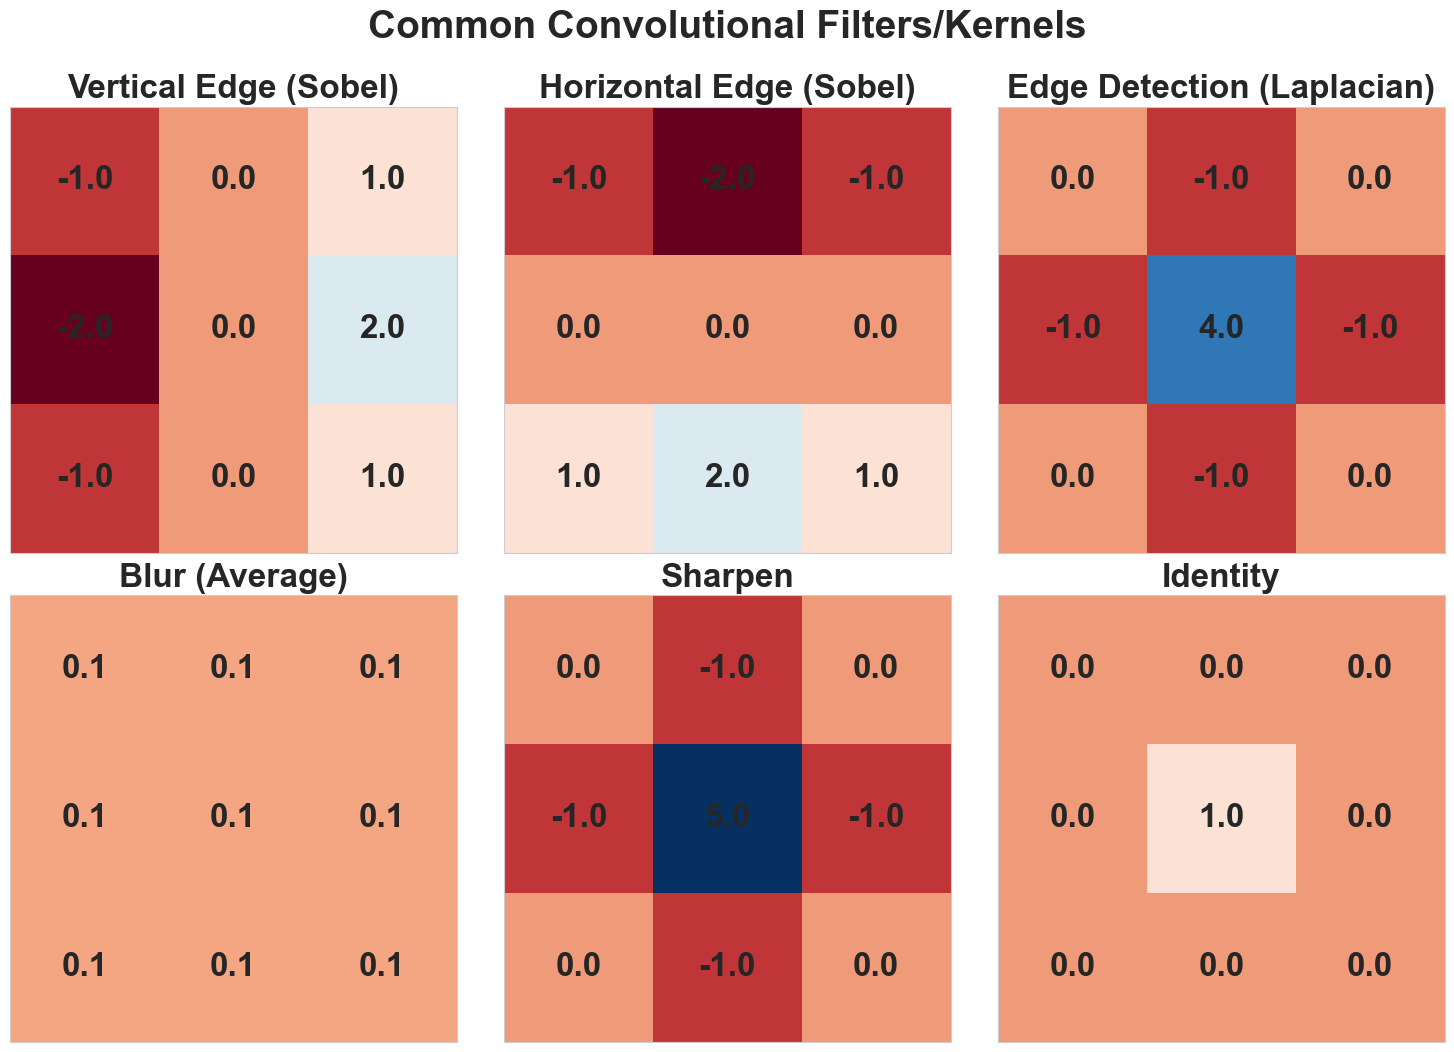

Each filter detects different features:
• Vertical/Horizontal Edge filters detect boundaries
• Laplacian detects general edges
• Blur smooths the image
• Sharpen enhances edges
• Identity preserves the original image


In [3]:
# Define common edge detection filters
filters = {
    'Vertical Edge (Sobel)':np.array([
                                    [-1, 0, 1],
                                    [-2, 0, 2],
                                    [-1, 0, 1]]),
    
    'Horizontal Edge (Sobel)':np.array([[-1, -2, -1],
                                        [ 0,  0,  0],
                                        [ 1,  2,  1]]),
    
    'Edge Detection (Laplacian)': np.array([[ 0, -1,  0],
                                            [-1,  4, -1],
                                            [ 0, -1,  0]]),
    
    'Blur (Average)': np.array([[1, 1, 1],
                                [1, 1, 1],
                                [1, 1, 1]]) / 9,
    
    'Sharpen': np.array([
                        [ 0, -1,  0],
                        [-1,  5, -1],
                        [ 0, -1,  0]]),
    
    'Identity': np.array([
                        [0, 0, 0],
                        [0, 1, 0],
                        [0, 0, 0]])
}

# Visualize the filters
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (name, kernel) in enumerate(filters.items()):
    im = axes[i].imshow(kernel, cmap='RdBu', vmin=-2, vmax=5)
    axes[i].set_title(f'{name}', fontsize=24, fontweight='bold')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
    # Add text annotations for values
    for row in range(kernel.shape[0]):
        for col in range(kernel.shape[1]):
            axes[i].text(col, row, f'{kernel[row, col]:.1f}', 
                        ha='center', va='center', fontsize=24, fontweight='bold')
plt.tight_layout()
plt.suptitle('Common Convolutional Filters/Kernels', fontsize=28, fontweight='bold', y=1.05)
plt.show()

print("Each filter detects different features:")
print("• Vertical/Horizontal Edge filters detect boundaries")
print("• Laplacian detects general edges")
print("• Blur smooths the image")
print("• Sharpen enhances edges")
print("• Identity preserves the original image")

### 3.2 Applying Filters to Images: Convolution in Action

Now let's see how these filters transform our MNIST digit. We'll apply each filter and observe the results.


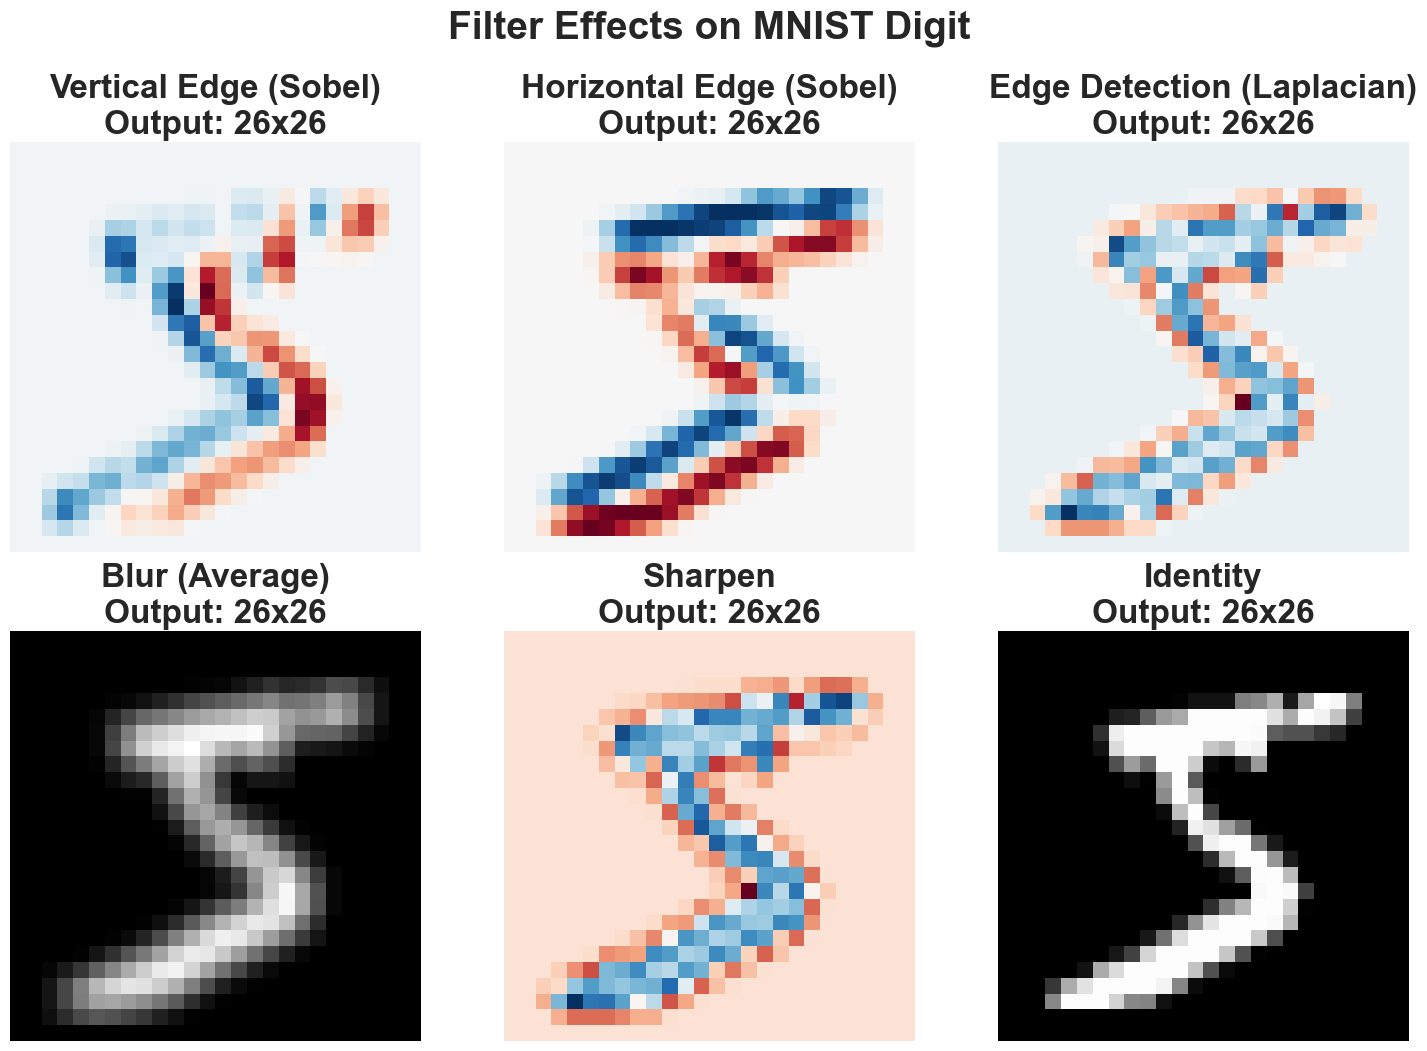

Key observations:
• Edge filters highlight boundaries and strokes
• The output size is smaller than input (28x28 → 26x26)
• Different filters capture different aspects of the digit
• Some filters enhance features while others smooth them


In [4]:
def apply_convolution(image, kernel):
    """Apply convolution manually to understand the process"""
    # Get dimensions
    img_h, img_w = image.shape
    kernel_h, kernel_w = kernel.shape
    
    # Calculate output dimensions (without padding)
    out_h = img_h - kernel_h + 1
    out_w = img_w - kernel_w + 1
    
    # Initialize output
    output = np.zeros((out_h, out_w))
    
    # Apply convolution
    for i in range(out_h):
        for j in range(out_w):
            # Extract the region
            region = image[i:i+kernel_h, j:j+kernel_w]
            # Apply the filter (element-wise multiplication and sum)
            output[i, j] = np.sum(region * kernel)
    
    return output

# Apply all filters to our sample image
filtered_images = {}
for name, kernel in filters.items():
    filtered_images[name] = apply_convolution(original_image, kernel)

# Visualize the results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original image in center
# axes[1, 1].imshow(original_image, cmap='gray')
# axes[1, 1].set_title('Original Image', fontsize=20, fontweight='bold')
# axes[1, 1].axis('off')

# Plot filtered results around the original
positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
filter_names = list(filtered_images.keys())

for i, (row, col) in enumerate(positions):
    if i < len(filter_names):
        name = filter_names[i]
        filtered_img = filtered_images[name]
        if 'Edge' in name or 'Sharpen' in name or 'Laplacian' in name:
            cmap = 'RdBu'
        else:
            cmap = 'gray'
        axes[row, col].imshow(filtered_img, cmap=cmap)
        axes[row, col].set_title(f'{name}\nOutput: {filtered_img.shape[0]}x{filtered_img.shape[1]}',
                                fontsize=24, fontweight='bold')
        axes[row, col].axis('off')
    else:
        axes[row, col].axis('off')

plt.tight_layout()
plt.suptitle('Filter Effects on MNIST Digit', fontsize=28, fontweight='bold', y=1.05)
plt.show()

print("Key observations:")
print("• Edge filters highlight boundaries and strokes")
print("• The output size is smaller than input (28x28 → 26x26)")
print("• Different filters capture different aspects of the digit")
print("• Some filters enhance features while others smooth them")

### 3.3 Understanding Convolution Step-by-Step

Let's visualize exactly how convolution works by showing the sliding window process.


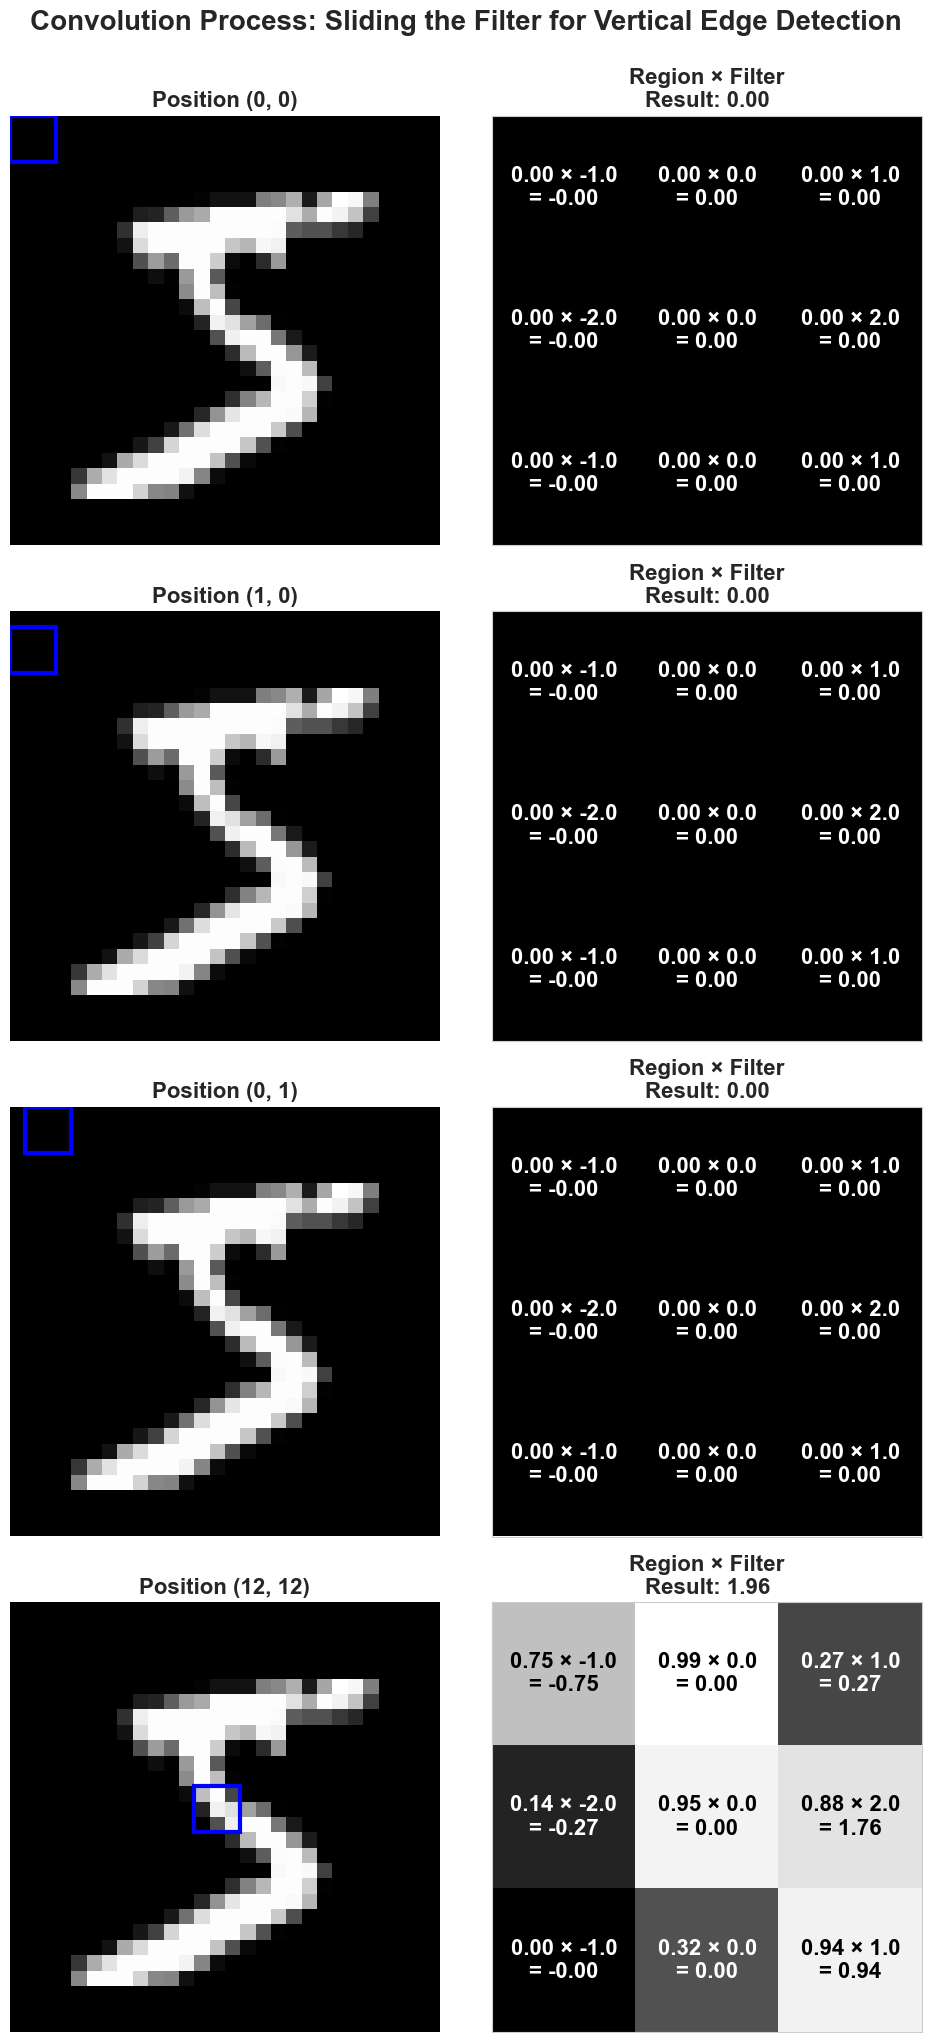

How convolution works:
1. Place the 3×3 filter at each position on the image
2. Multiply each filter value with the corresponding pixel value
3. Sum all the products to get the output value
4. Move the filter one step and repeat

Note: The blue rectangle shows where the filter is currently applied!


In [5]:
def visualize_convolution_steps(image, kernel, positions=[(0, 0), (1, 0), (0, 1), (12, 12)]):
    """Visualize the convolution process step by step"""
    
    fig, axes = plt.subplots(len(positions), 2, figsize=(10, 20))
    
    for idx, (i, j) in enumerate(positions):
        # Extract the 3x3 region
        region = image[i:i+3, j:j+3]
        
        # Calculate the convolution result for this position
        conv_result = np.sum(region * kernel)
        
        # Top row: Show the image with highlighted region
        axes[idx, 0].imshow(image, cmap='gray')
        
        # Add rectangle to highlight the current region
        from matplotlib.patches import Rectangle
        rect = Rectangle((j-0.5, i-0.5), 3, 3, linewidth=3, edgecolor='blue', facecolor='none')
        axes[idx, 0].add_patch(rect)
        
        axes[idx, 0].set_title(f'Position ({i}, {j})', fontsize=16, fontweight='bold')
        axes[idx, 0].axis('off')
        
        # Bottom row: Show the extracted region and calculation
        axes[idx, 1].imshow(region, cmap='gray')
        axes[idx, 1].set_title(f'Region × Filter\nResult: {conv_result:.2f}', fontsize=16, fontweight='bold')
        
        # Add text overlay showing the calculation
        for row in range(3):
            for col in range(3):
                pixel_val = region[row, col]
                filter_val = kernel[row, col]
                product = pixel_val * filter_val
                
                color = 'white' if pixel_val < 0.5 else 'black'
                axes[idx, 1].text(col, row, f'{pixel_val:.2f} × {filter_val:.1f}\n= {product:.2f}', 
                                ha='center', va='center', fontsize=16, color=color, fontweight='bold')
        axes[idx, 1].set_xticks([])
        axes[idx, 1].set_yticks([])
        
    plt.tight_layout()
    
    text = plt.suptitle('Convolution Process: Sliding the Filter for Vertical Edge Detection',
                        fontsize=20, fontweight='bold', x=0.5, y=1.02)
    
    plt.show()

vertical_filter = filters['Vertical Edge (Sobel)']
visualize_convolution_steps(original_image, vertical_filter)

print("How convolution works:")
print("1. Place the 3×3 filter at each position on the image")
print("2. Multiply each filter value with the corresponding pixel value")
print("3. Sum all the products to get the output value")
print("4. Move the filter one step and repeat")
print("\nNote: The blue rectangle shows where the filter is currently applied!")

### 3.4 PyTorch Convolution: The Professional Way

Now let's see how PyTorch handles convolution operations with proper tensor operations.


Original image shape: (28, 28)
PyTorch tensor shape: torch.Size([1, 1, 28, 28]) (batch, channels, height, width)

Convolutional layer parameters:
Input channels: 1 (grayscale)
Output channels: 6 (6 different filters)
Kernel size: 3×3
Stride: 1 (move filter 1 pixel at a time)
Padding: 0 (no padding)

Output shape: torch.Size([1, 6, 26, 26])
We now have 6 feature maps of size 26×26


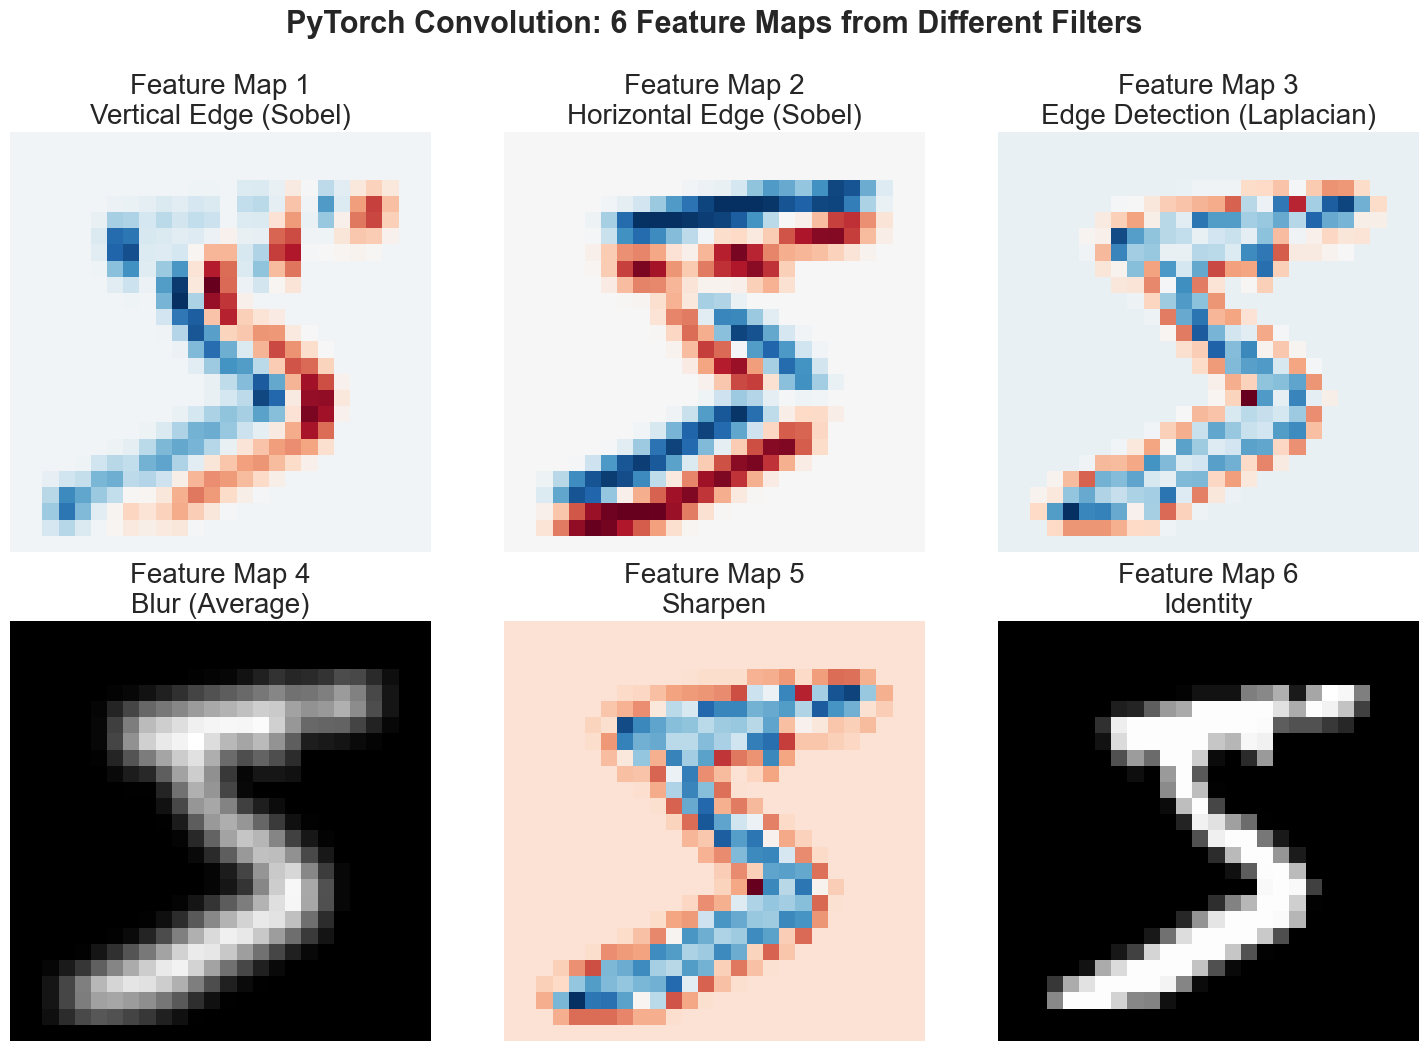


Key insights:
• One input image → 6 feature maps (one per filter)
• Each feature map captures different aspects of the image
• This is how CNNs learn to detect various features!


In [6]:
# Convert our image to PyTorch tensor format
# PyTorch expects input as (batch_size, channels, height, width)
image_tensor = torch.tensor(original_image).unsqueeze(0).unsqueeze(0).float()
print(f"Original image shape: {original_image.shape}")
print(f"PyTorch tensor shape: {image_tensor.shape} (batch, channels, height, width)")

# Create a convolutional layer
conv_layer = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=0, bias=False)

print(f"\nConvolutional layer parameters:")
print(f"Input channels: 1 (grayscale)")
print(f"Output channels: 6 (6 different filters)")
print(f"Kernel size: 3×3")
print(f"Stride: 1 (move filter 1 pixel at a time)")
print(f"Padding: 0 (no padding)")

# Initialize with our custom filters (let's use a few of them)
with torch.no_grad():
    # Convert our numpy filters to PyTorch format
    custom_filters = torch.zeros(6, 1, 3, 3)
    filter_list = list(filters.values())
    
    for i in range(6):
        custom_filters[i, 0] = torch.tensor(filter_list[i])
    
    conv_layer.weight.data = custom_filters

# Apply convolution
output = conv_layer(image_tensor)
print(f"\nOutput shape: {output.shape}")
print(f"We now have 6 feature maps of size 26×26")

# Visualize the results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

filter_names_subset = list(filters.keys())[:6]

for i in range(6):
    feature_map = output[0, i].detach().numpy()
    
    if 'Edge' in filter_names_subset[i] or 'Sharpen' in filter_names_subset[i] or 'Laplacian' in filter_names_subset[i]:
        cmap = 'RdBu'
    else:
        cmap = 'gray'
        
    axes[i].imshow(feature_map, cmap=cmap)
    axes[i].set_title(f'Feature Map {i+1}\n{filter_names_subset[i]}', fontsize=20)
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('PyTorch Convolution: 6 Feature Maps from Different Filters',
            fontsize=22, fontweight='bold', y=1.05)
plt.show()

print("\nKey insights:")
print("• One input image → 6 feature maps (one per filter)")
print("• Each feature map captures different aspects of the image")
print("• This is how CNNs learn to detect various features!")

## 4. Building Blocks of CNNs

Now that we understand convolution, let's explore the complete CNN architecture with all its components.


### 4.1 Activation Functions: Introducing Non-linearity

After convolution, we apply activation functions to introduce non-linearity. The most common is ReLU (Rectified Linear Unit).


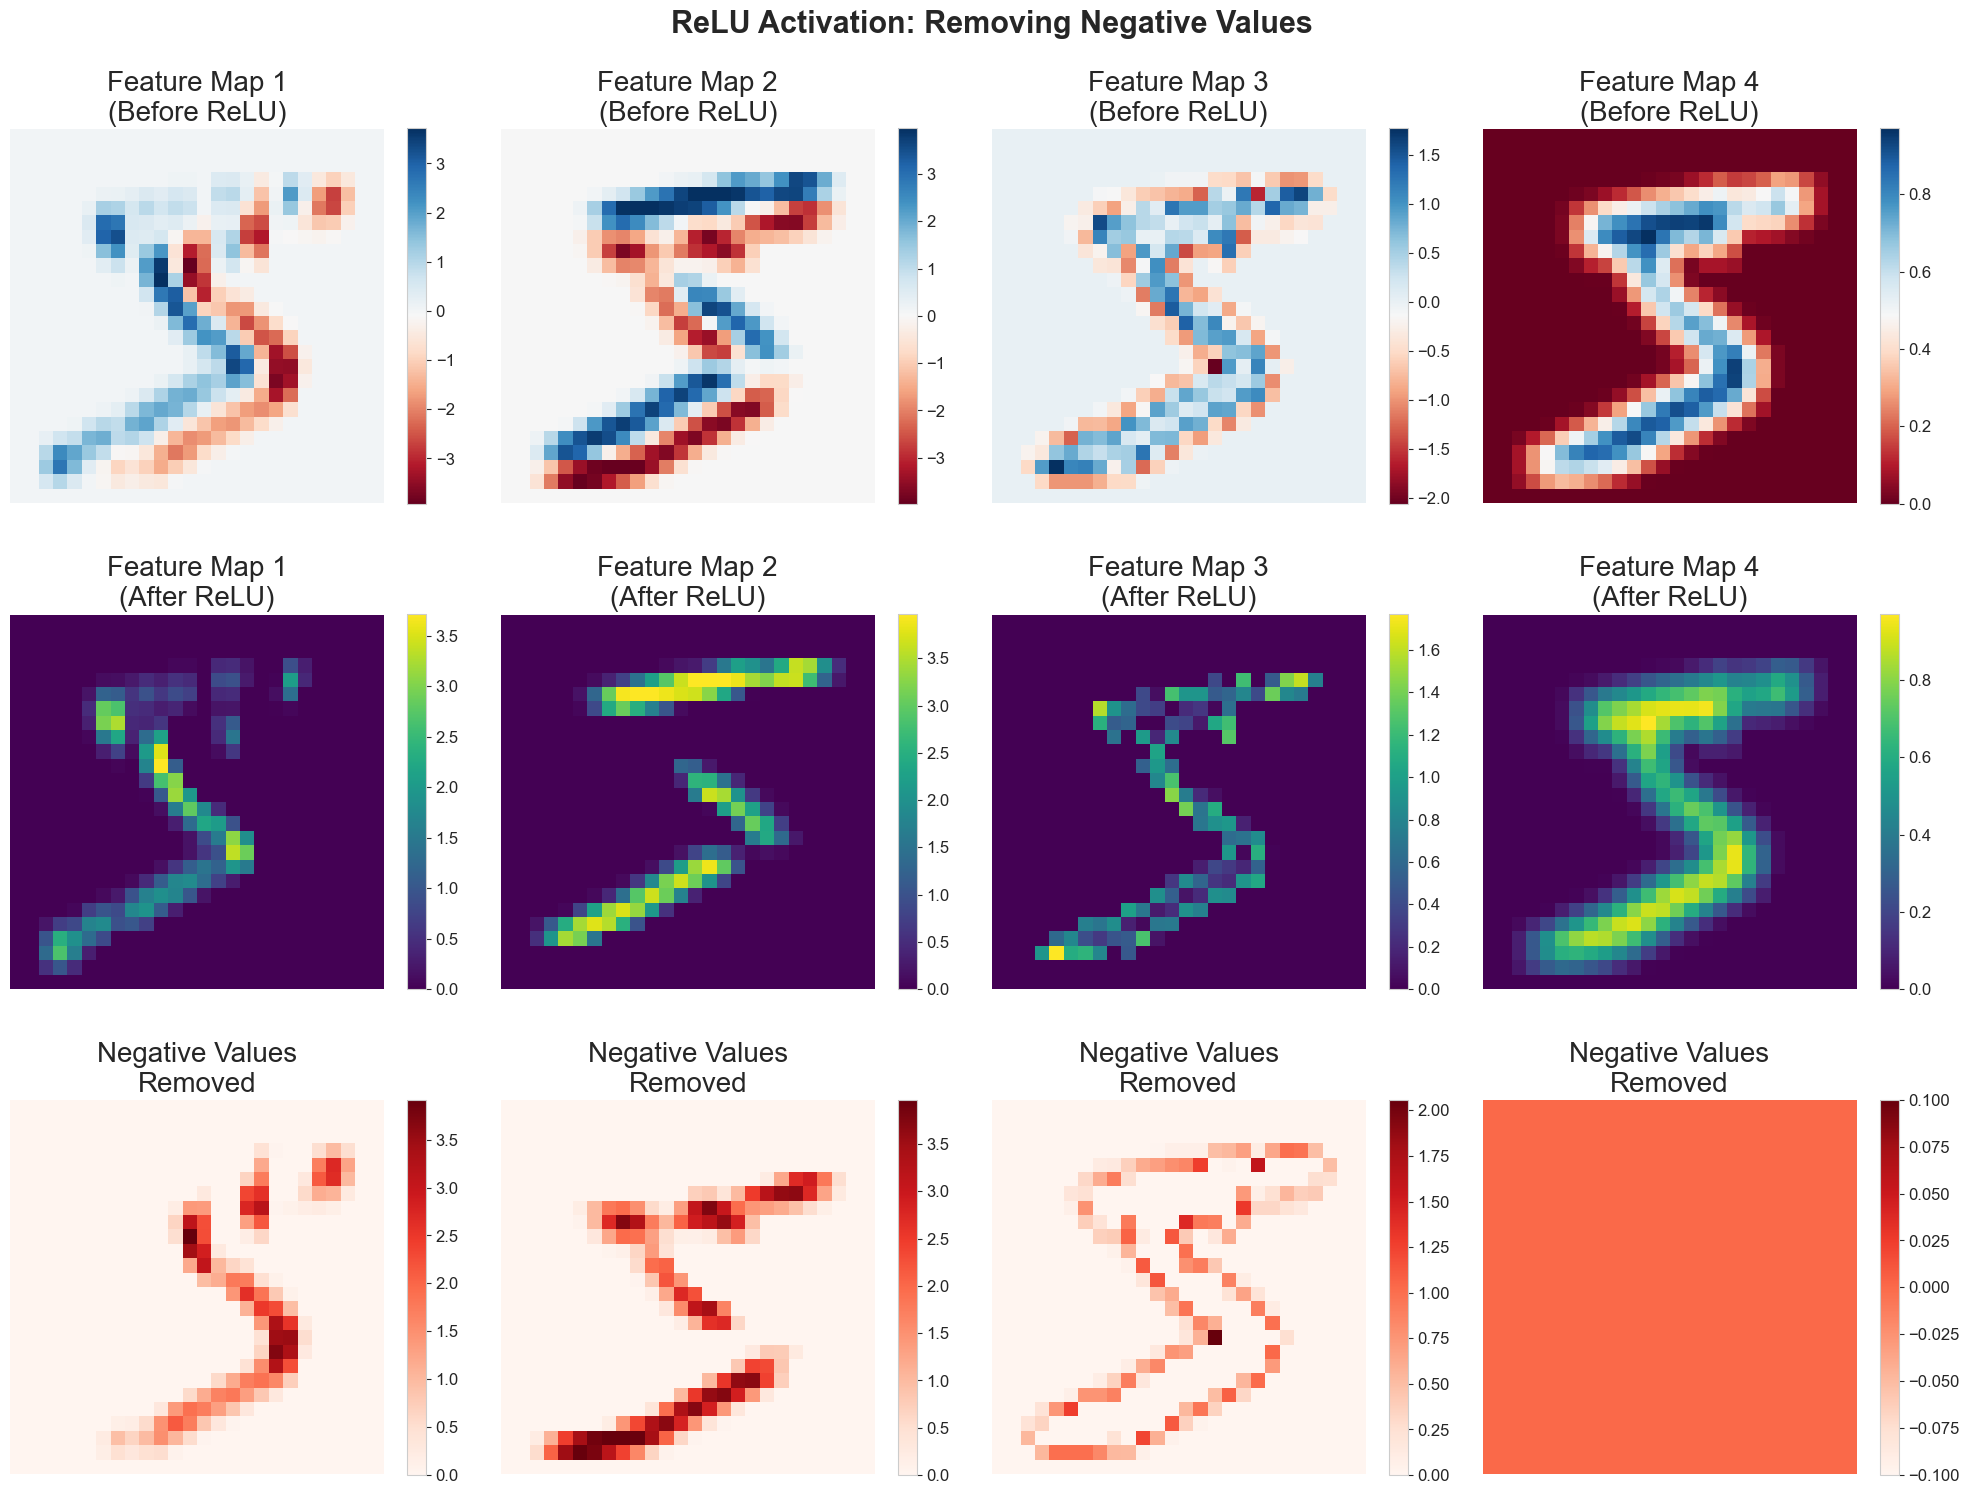

ReLU Activation Function:
• ReLU(x) = max(0, x)
• Removes all negative values (sets them to 0)
• Keeps positive values unchanged
• Introduces non-linearity essential for learning complex patterns
• Fast to compute and helps with gradient flow


In [7]:
# Apply ReLU activation to our feature maps
relu = nn.ReLU()
activated_output = relu(output)

# Compare before and after ReLU
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for i in range(4):
    # Original feature map
    original_fm = output[0, i].detach().numpy()
    activated_fm = activated_output[0, i].detach().numpy()
    
    # Plot original
    im1 = axes[0, i].imshow(original_fm, cmap='RdBu')
    axes[0, i].set_title(f'Feature Map {i+1}\n(Before ReLU)', fontsize=20)
    axes[0, i].axis('off')
    plt.colorbar(im1, ax=axes[0, i], shrink=0.8)
    
    # Plot after ReLU
    im2 = axes[1, i].imshow(activated_fm, cmap='viridis')
    axes[1, i].set_title(f'Feature Map {i+1}\n(After ReLU)', fontsize=20)
    axes[1, i].axis('off')
    plt.colorbar(im2, ax=axes[1, i], shrink=0.8)
    
    # Plot the difference
    difference = activated_fm - original_fm
    im3 = axes[2, i].imshow(difference, cmap='Reds')
    axes[2, i].set_title(f'Negative Values\nRemoved', fontsize=20)
    axes[2, i].axis('off')
    plt.colorbar(im3, ax=axes[2, i], shrink=0.8)

plt.tight_layout()
plt.suptitle('ReLU Activation: Removing Negative Values', fontsize=22, fontweight='bold', y=1.02)
plt.show()

print("ReLU Activation Function:")
print("• ReLU(x) = max(0, x)")
print("• Removes all negative values (sets them to 0)")
print("• Keeps positive values unchanged")
print("• Introduces non-linearity essential for learning complex patterns")
print("• Fast to compute and helps with gradient flow")

### 4.2 Pooling Layers: Reducing Spatial Dimensions

Pooling layers reduce the spatial size of feature maps while retaining important information. The most common is Max Pooling.


Before pooling: torch.Size([1, 6, 26, 26])
After pooling: torch.Size([1, 6, 13, 13])
Size reduction: 26x26 → 13x13 (roughly half)


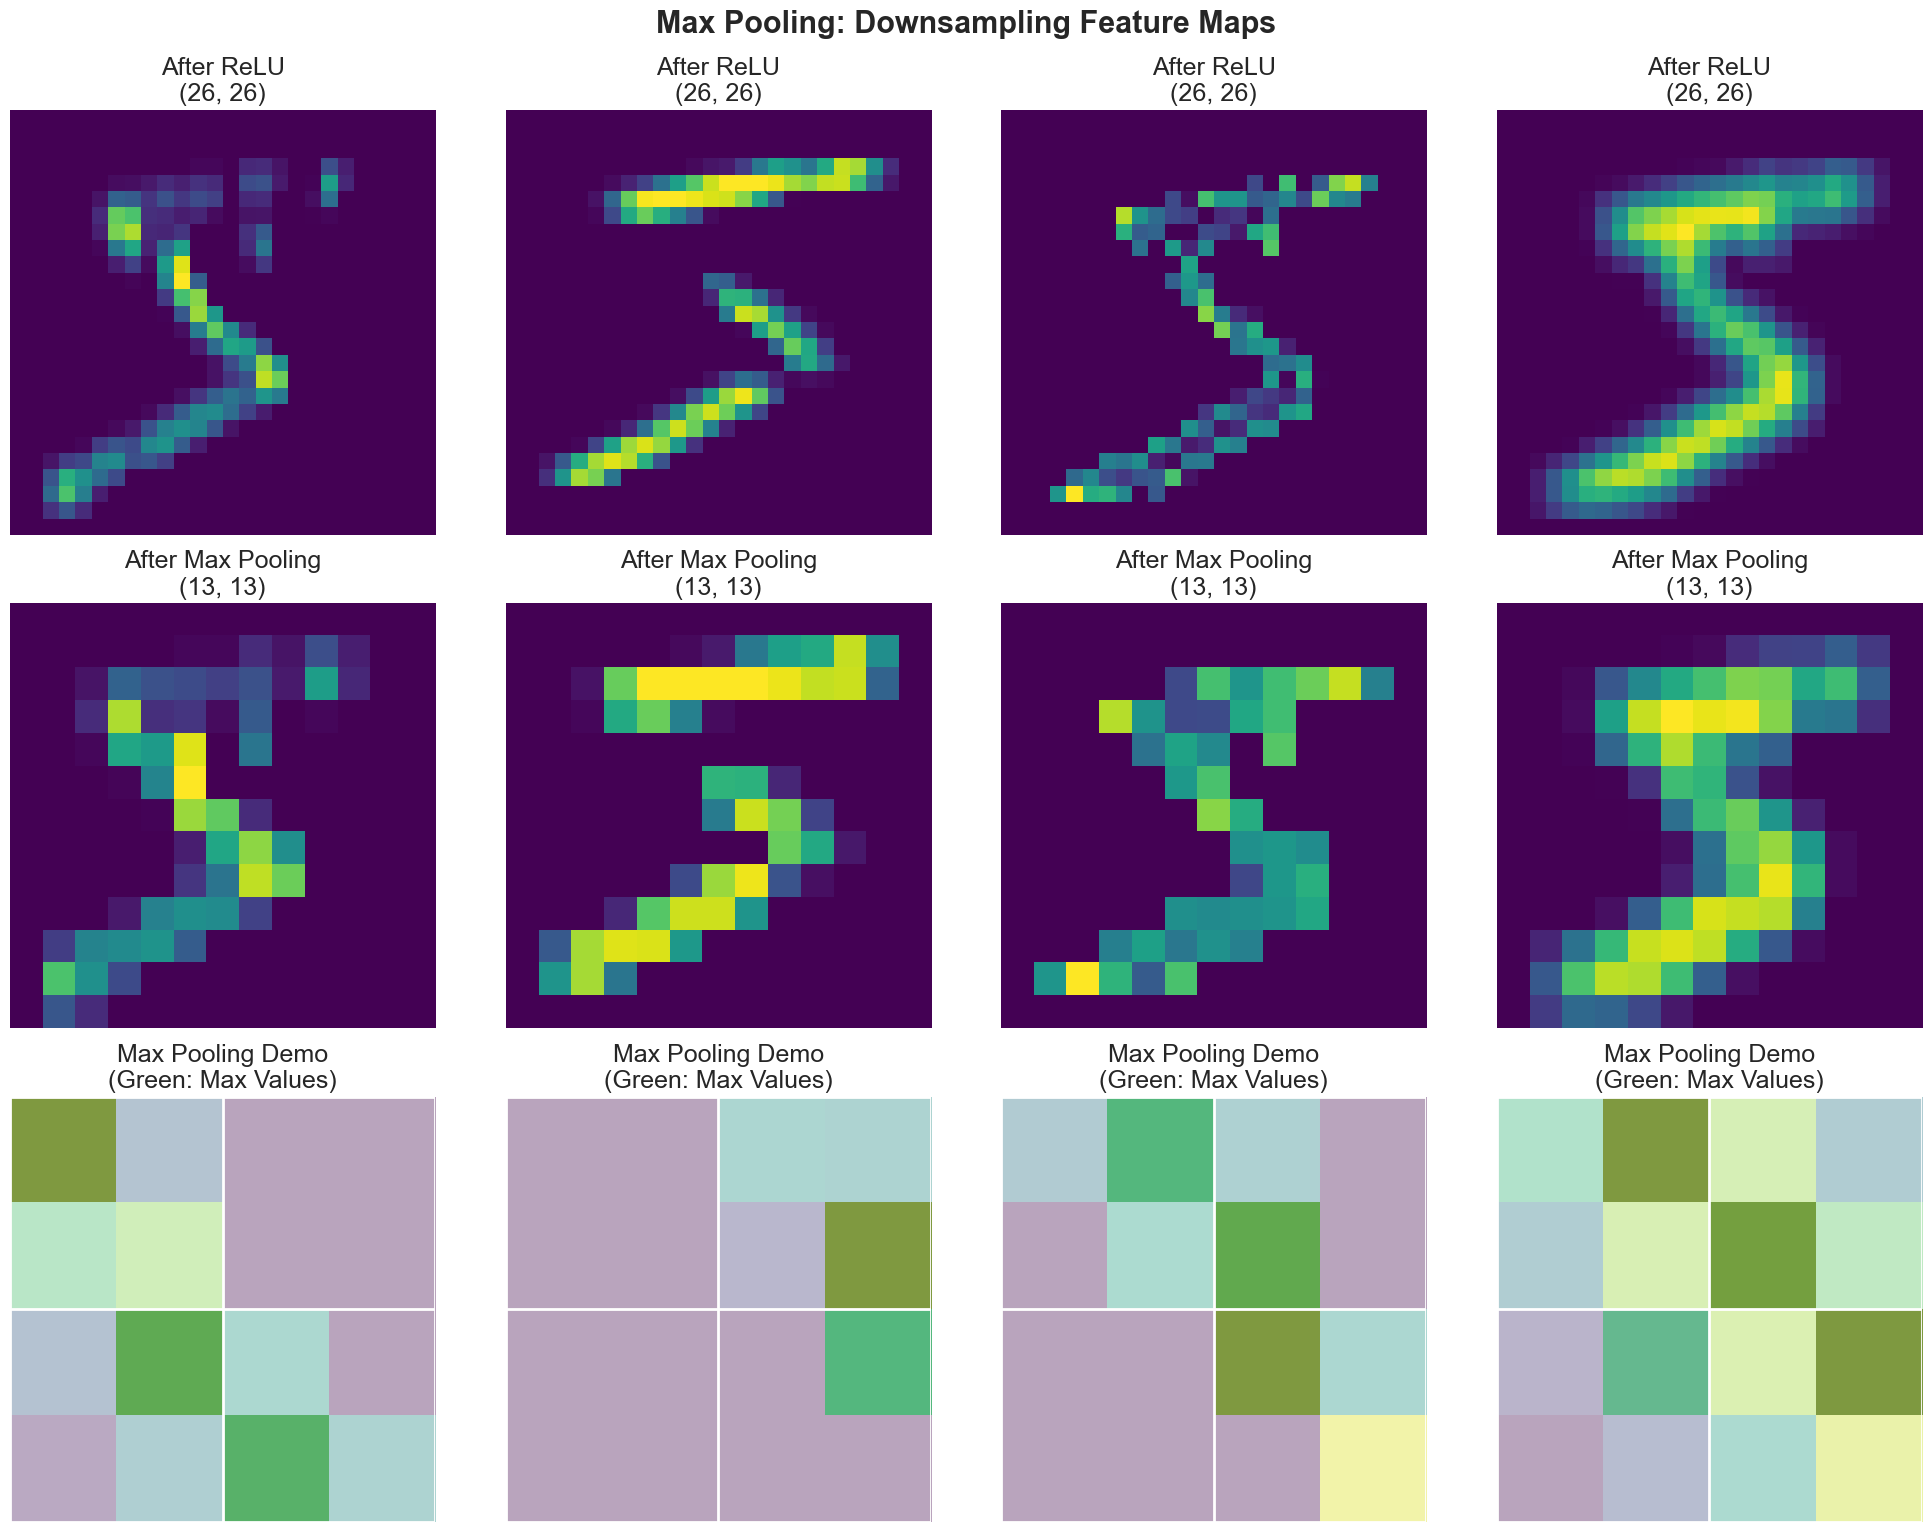

Max Pooling Benefits:
• Reduces computational load (smaller feature maps)
• Provides translation invariance
• Retains the most important features (maximum values)
• Reduces overfitting by reducing parameters
• Maintains the depth (number of channels) unchanged


In [8]:
# Create max pooling layer
maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

# Apply max pooling to our activated feature maps
pooled_output = maxpool(activated_output)

print(f"Before pooling: {activated_output.shape}")
print(f"After pooling: {pooled_output.shape}")
print(f"Size reduction: {activated_output.shape[2]}x{activated_output.shape[3]} → {pooled_output.shape[2]}x{pooled_output.shape[3]} (roughly half)")

# Visualize the pooling effect
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for i in range(4):
    # Original activated feature map
    original = activated_output[0, i].detach().numpy()
    pooled = pooled_output[0, i].detach().numpy()
    
    # Show original
    axes[0, i].imshow(original, cmap='viridis')
    axes[0, i].set_title(f'After ReLU\n{original.shape}', fontsize=18)
    axes[0, i].axis('off')
    
    # Show pooled
    axes[1, i].imshow(pooled, cmap='viridis')
    axes[1, i].set_title(f'After Max Pooling\n{pooled.shape}', fontsize=18)
    axes[1, i].axis('off')
    
    # Show how max pooling works on a small region
    # Take a 4x4 region and show the 2x2 result
    sample_region = original[10:14, 10:14]  # 4x4 region
    pooled_region = pooled[5:7, 5:7]        # corresponding 2x2 result
    
    # Create visualization of max pooling process
    pooling_demo = np.zeros((4, 4))
    for row in range(0, 4, 2):
        for col in range(0, 4, 2):
            region_2x2 = sample_region[row:row+2, col:col+2]
            max_val = np.max(region_2x2)
            max_pos = np.unravel_index(np.argmax(region_2x2), region_2x2.shape)
            pooling_demo[row+max_pos[0], col+max_pos[1]] = max_val
    
    axes[2, i].imshow(sample_region, cmap='viridis', alpha=0.7)
    axes[2, i].imshow(pooling_demo, cmap='Greens', alpha=0.5)
    axes[2, i].set_title(f'Max Pooling Demo\n(Green: Max Values)', fontsize=18)
    axes[2, i].axis('off')
    
    # Add grid to show pooling regions
    for j in range(0, 5, 2):
        axes[2, i].axhline(j-0.5, color='white', linewidth=2)
        axes[2, i].axvline(j-0.5, color='white', linewidth=2)

plt.tight_layout()
plt.suptitle('Max Pooling: Downsampling Feature Maps', fontsize=22, fontweight='bold', y=1.02)
plt.show()

print("Max Pooling Benefits:")
print("• Reduces computational load (smaller feature maps)")
print("• Provides translation invariance")
print("• Retains the most important features (maximum values)")
print("• Reduces overfitting by reducing parameters")
print("• Maintains the depth (number of channels) unchanged")

### 4.3 CNN Layer Hierarchy: From Edges to Objects

CNNs learn hierarchical features. Let's build a complete CNN and visualize how features become more complex in deeper layers.


In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)  # 28x28 -> 14x14
        
        # Second convolutional block  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 14x14 -> 14x14
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)  # 14x14 -> 7x7
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 7x7 -> 7x7
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)  # 7x7 -> 3x3
        
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST
        
    def forward(self, x):
        # Store intermediate outputs for visualization
        features = {}
        
        # Layer 1
        x = self.conv1(x)
        features['conv1'] = x.clone()
        x = self.relu1(x)
        features['relu1'] = x.clone()
        x = self.pool1(x)
        features['pool1'] = x.clone()
        
        # Layer 2
        x = self.conv2(x)
        features['conv2'] = x.clone()
        x = self.relu2(x)
        features['relu2'] = x.clone()
        x = self.pool2(x)
        features['pool2'] = x.clone()
        
        # Layer 3
        x = self.conv3(x)
        features['conv3'] = x.clone()
        x = self.relu3(x)
        features['relu3'] = x.clone()
        x = self.pool3(x)
        features['pool3'] = x.clone()
        
        # Flatten and fully connected
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        
        return x, features

# Create the model
model = SimpleCNN()
print("CNN Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Pass our image through the network
with torch.no_grad():
    output, features = model(image_tensor)

print(f"Feature map shapes at each layer:")
for layer_name, feature_map in features.items():
    print(f"{layer_name}: {feature_map.shape}")

CNN Architecture:
SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Total parameters: 98,442
Feature map shapes at each layer:
conv1: torch.Size([1, 16, 28, 28])
relu1: torch.Size([1, 16, 28, 28])
pool1: torch.Size([1, 16, 14, 14])
conv2: torch.Size([1, 32, 14, 14])
relu2: torch.Size([1, 32, 14, 14])
pool2:

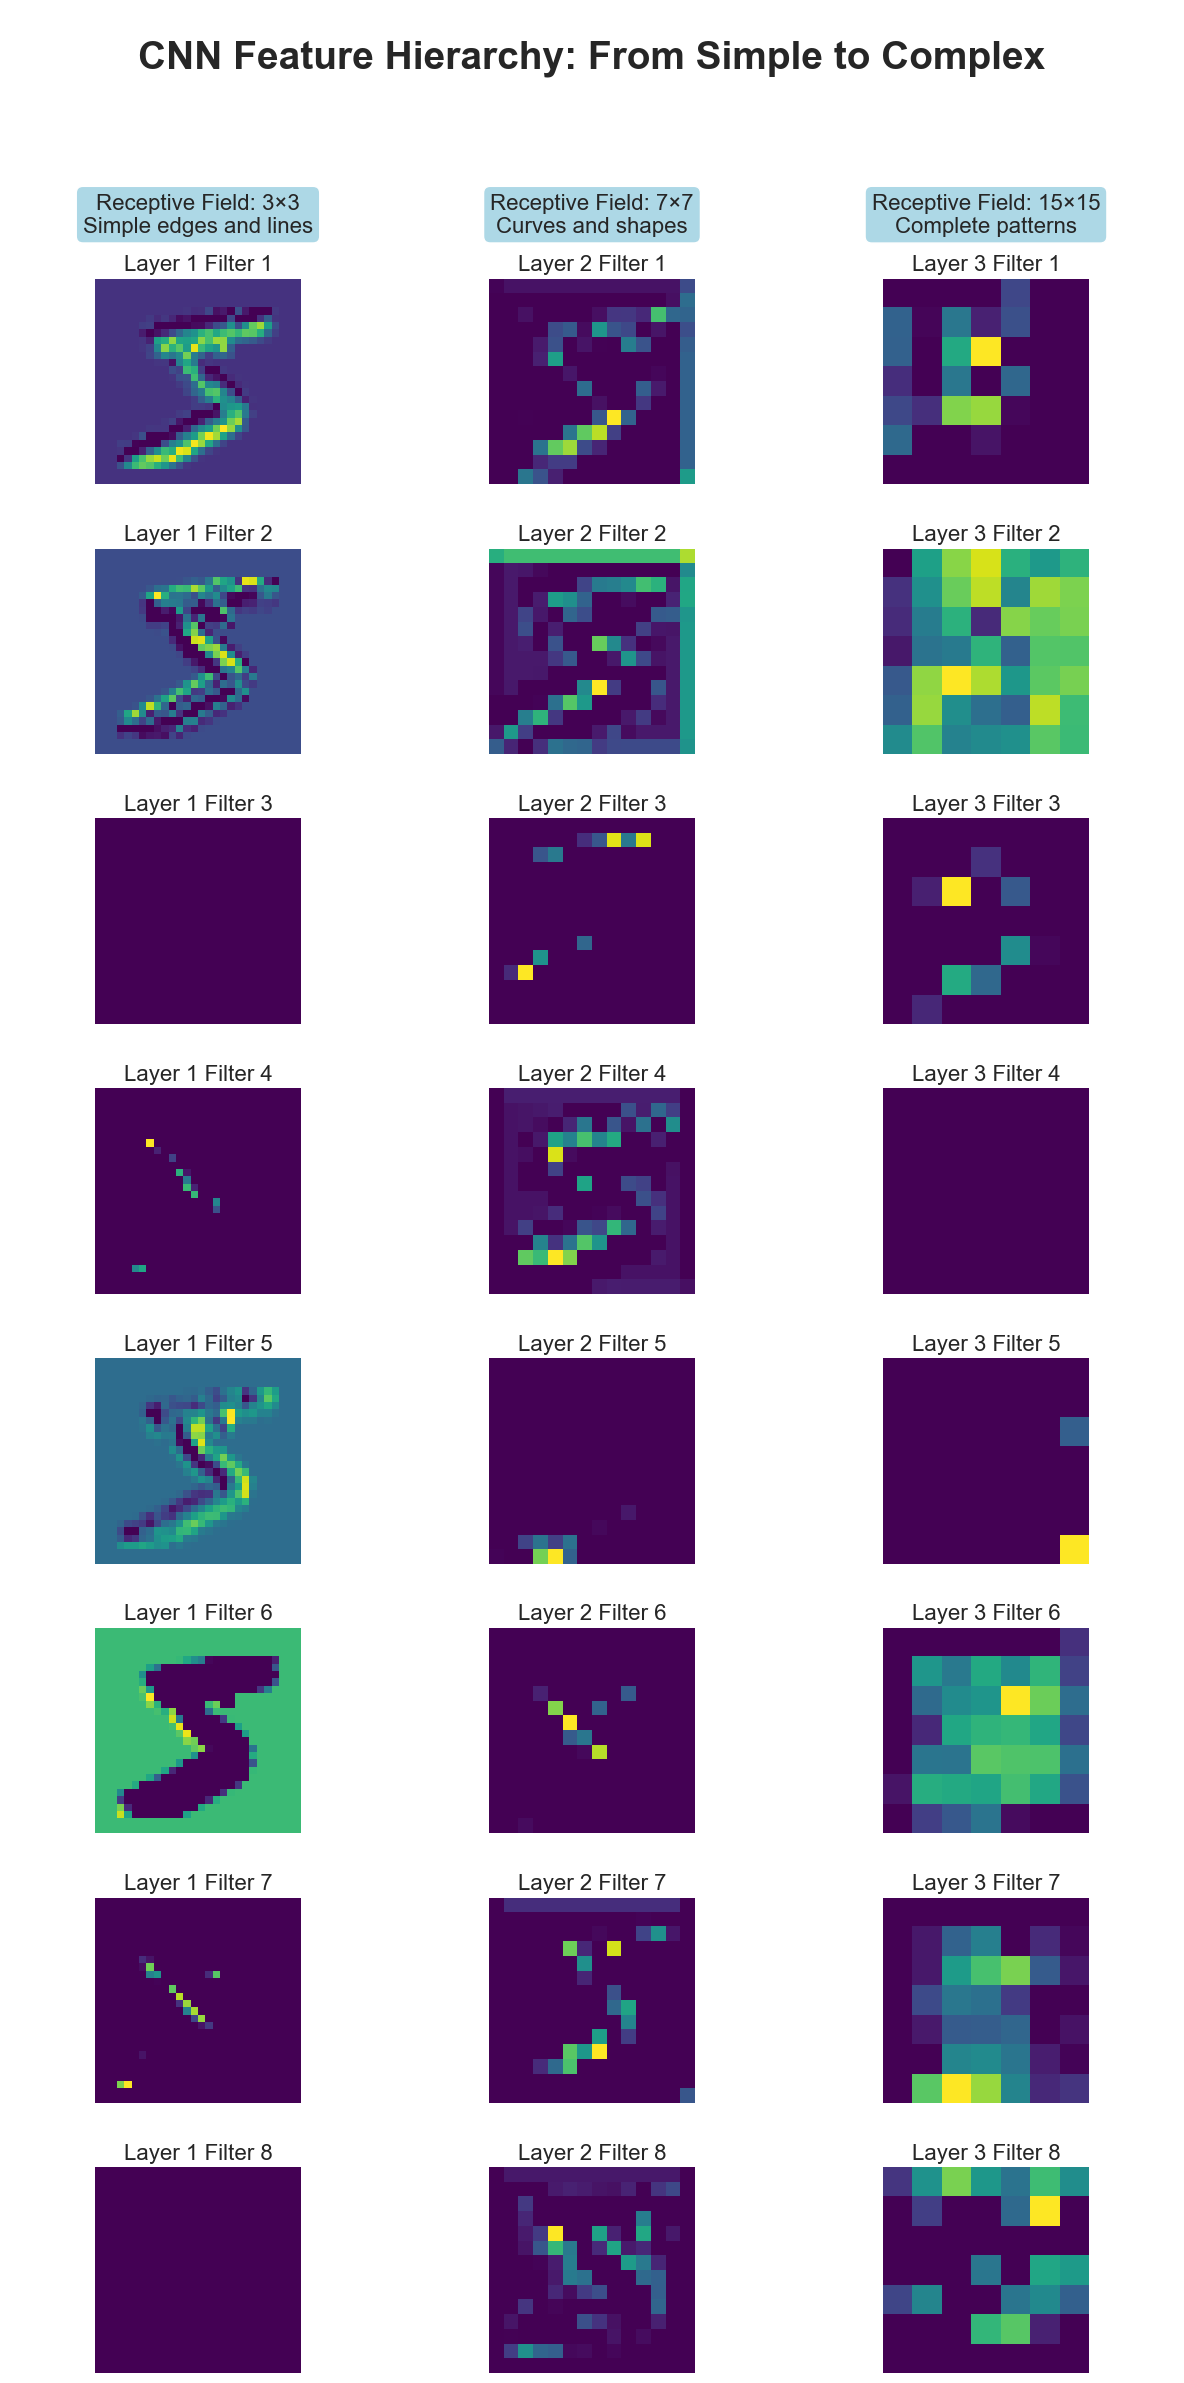

Feature Hierarchy in CNNs:
Layer 1 (Shallow):
  • Small receptive field (3×3)
  • Detects simple features: edges, lines, curves
  • High spatial resolution (28×28)
Layer 2 (Medium):
  • Larger receptive field (7×7)
  • Combines simple features into shapes
  • Medium spatial resolution (14×14)
Layer 3 (Deep):
  • Large receptive field (15×15)
  • Detects complex patterns and objects
  • Lower spatial resolution (7×7)
This hierarchical learning is what makes CNNs so powerful for image recognition!


In [10]:
# Visualize feature hierarchy across layers
fig, axes = plt.subplots(9, 3, figsize=(12, 24))
font_size = 16
# Layer 1 features (after ReLU)
layer1_features = features['relu1'][0]  # Shape: (16, 28, 28)
for i in range(8):
    axes[i+1, 0].imshow(layer1_features[i].numpy(), cmap='viridis')
    axes[i+1, 0].set_title(f'Layer 1 Filter {i+1}', fontsize=font_size)
    axes[i+1, 0].axis('off')

# Layer 2 features (after ReLU)  
layer2_features = features['relu2'][0]  # Shape: (32, 14, 14)
for i in range(8):
    axes[i+1, 1].imshow(layer2_features[i].numpy(), cmap='viridis')
    axes[i+1, 1].set_title(f'Layer 2 Filter {i+1}', fontsize=font_size)
    axes[i+1, 1].axis('off')

# Layer 3 features (after ReLU)
layer3_features = features['relu3'][0]  # Shape: (64, 7, 7)
for i in range(8):
    axes[i+1, 2].imshow(layer3_features[i].numpy(), cmap='viridis')
    axes[i+1, 2].set_title(f'Layer 3 Filter {i+1}', fontsize=font_size)
    axes[i+1, 2].axis('off')

# Show the receptive field concept
receptive_fields = ['3×3', '7×7', '15×15']
layer_descriptions = [
    'Simple edges and lines',
    'Curves and shapes',
    'Complete patterns'
]

for i in range(3):
    axes[0, i].text(0.5, 0.0, f'Receptive Field: {receptive_fields[i]}\n{layer_descriptions[i]}',
                    transform=axes[0, i].transAxes, ha='center', va='center', fontsize=font_size,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    axes[0, i].set_xlim(0, 1)
    axes[0, i].set_ylim(0, 1)
    axes[0, i].axis('off')

plt.tight_layout()
plt.suptitle('CNN Feature Hierarchy: From Simple to Complex', fontsize=28, fontweight='bold', y=0.98)
plt.show()

print("Feature Hierarchy in CNNs:")
print("Layer 1 (Shallow):")
print("  • Small receptive field (3×3)")
print("  • Detects simple features: edges, lines, curves")
print("  • High spatial resolution (28×28)")
print("Layer 2 (Medium):")
print("  • Larger receptive field (7×7)")
print("  • Combines simple features into shapes")
print("  • Medium spatial resolution (14×14)")
print("Layer 3 (Deep):")
print("  • Large receptive field (15×15)")
print("  • Detects complex patterns and objects")
print("  • Lower spatial resolution (7×7)")
print("This hierarchical learning is what makes CNNs so powerful for image recognition!")

## 5. Understanding CNN Parameters and Shapes

Let's dive deeper into how CNN layer parameters affect the output shapes and why padding and stride matter.


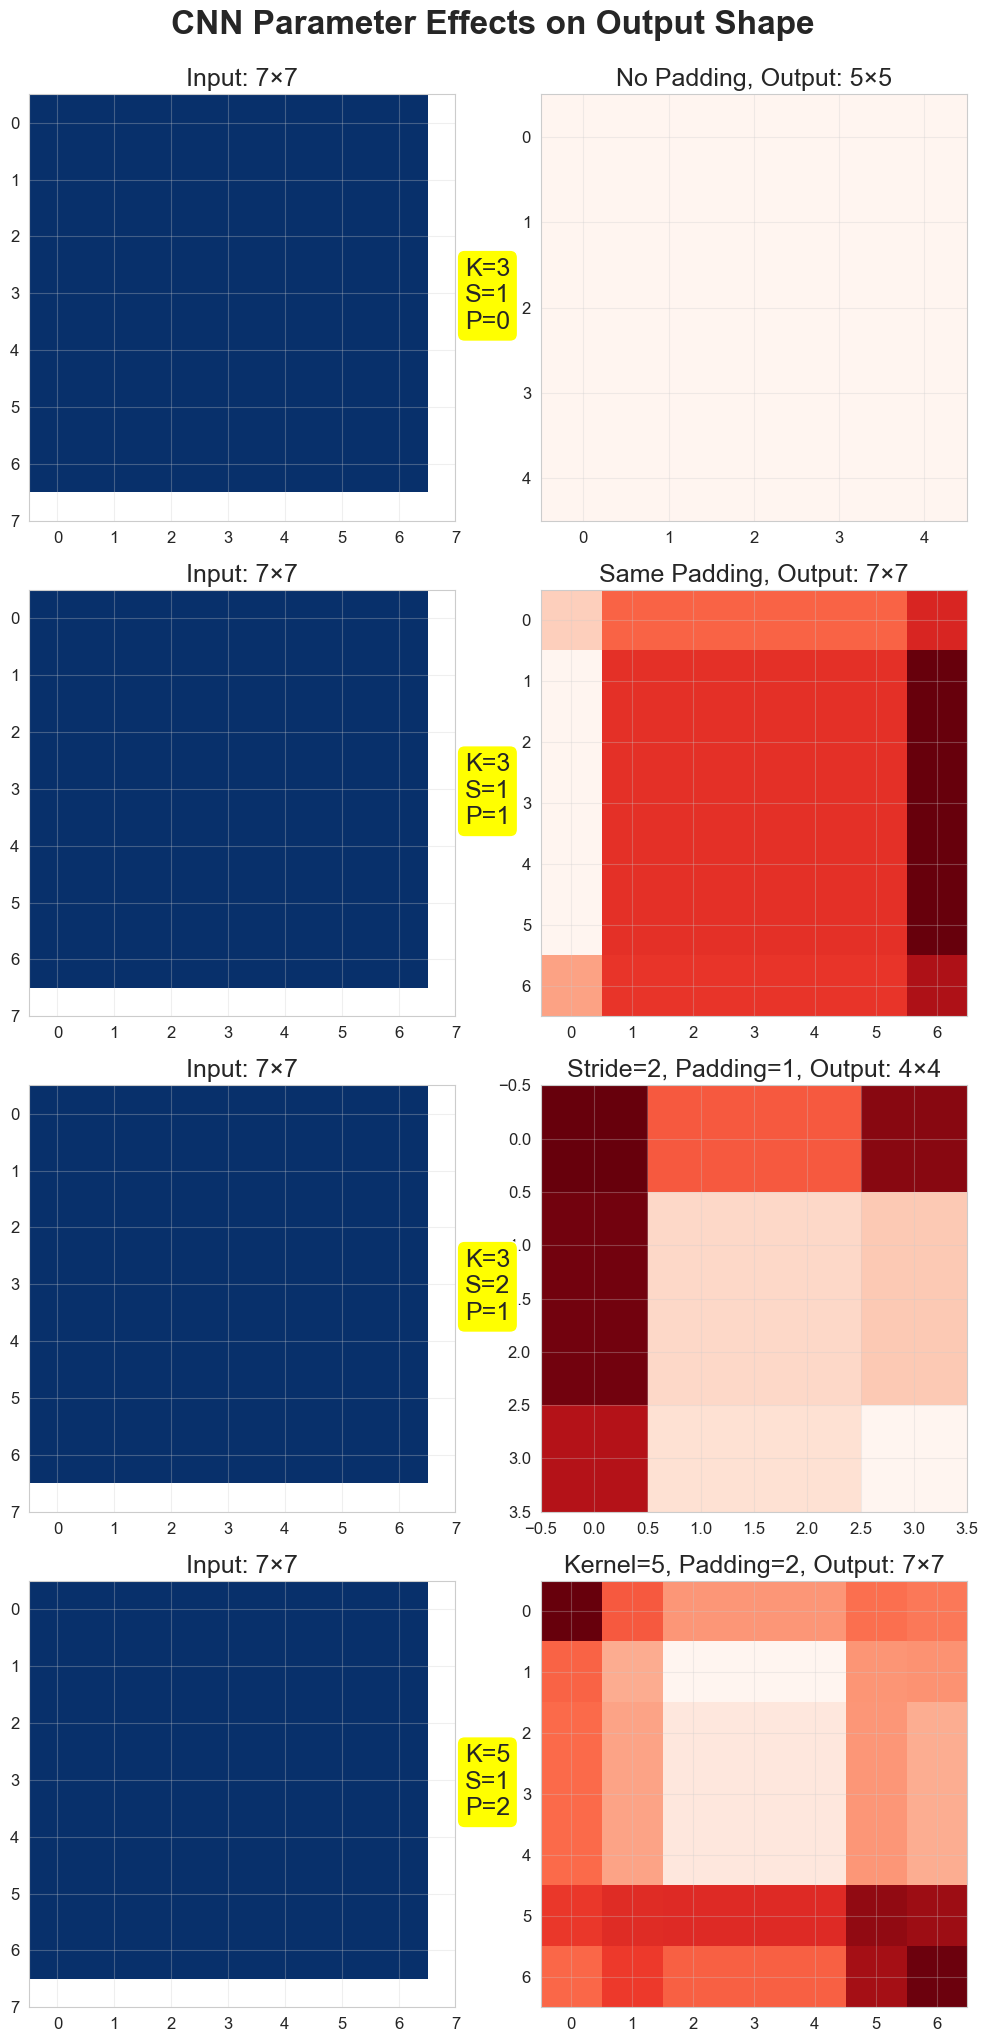

Output Size Formula:
Output = (Input + 2×Padding - Kernel_Size) ÷ Stride + 1


In [12]:
# Demonstrate different padding and stride effects
def demonstrate_conv_params():
    # Create test image
    test_image = torch.ones(1, 1, 7, 7)  # Simple 7x7 image
    
    # Different convolution configurations
    configs = [
        {'kernel_size': 3, 'stride': 1, 'padding': 0, 'name': 'No Padding'},
        {'kernel_size': 3, 'stride': 1, 'padding': 1, 'name': 'Same Padding'},
        {'kernel_size': 3, 'stride': 2, 'padding': 1, 'name': 'Stride=2, Padding=1'},
        {'kernel_size': 5, 'stride': 1, 'padding': 2, 'name': 'Kernel=5, Padding=2'},
    ]
    
    fig, axes = plt.subplots(4, 2, figsize=(10, 20))
    
    for i, config in enumerate(configs):
        # Create conv layer
        conv = nn.Conv2d(1, 1, **{k: v for k, v in config.items() if k != 'name'})
        
        # Apply convolution
        output = conv(test_image)
        
        # Calculate output size using formula
        input_size = 7
        kernel_size = config['kernel_size']
        stride = config['stride']
        padding = config['padding']
        
        output_size = (input_size + 2*padding - kernel_size) // stride + 1
        
        # Plot input
        axes[i, 0].imshow(test_image[0, 0].numpy(), cmap='Blues', vmin=0, vmax=1)
        axes[i, 0].set_title(f'Input: 7×7', fontsize=18)
        axes[i, 0].grid(True, alpha=0.3)
        axes[i, 0].set_xticks(range(8))
        axes[i, 0].set_yticks(range(8))
        
        # Plot output
        axes[i, 1].imshow(output[0, 0].detach().numpy(), cmap='Reds')
        axes[i, 1].set_title(f'{config["name"]}, Output: {output.shape[2]}×{output.shape[3]}', fontsize=18)
        axes[i, 1].grid(True, alpha=0.3)
        
        # Add parameter info
        param_text = f'K={kernel_size}\nS={stride}\nP={padding}'
        axes[i, 1].text(-0.125, 0.45, param_text, transform=axes[i, 1].transAxes, 
                        ha='center', fontsize=18, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
    
    plt.tight_layout()
    plt.suptitle('CNN Parameter Effects on Output Shape', fontsize=24, fontweight='bold', y=1.02)
    plt.show()

demonstrate_conv_params()

print("Output Size Formula:")
print("Output = (Input + 2×Padding - Kernel_Size) ÷ Stride + 1")

### Key Parameters:

• Kernel Size: Size of the filter (e.g., 3×3, 5×5)
• Stride: How many pixels to move the filter each step
• Padding: Extra pixels added around the image border

### Common Strategies:

• padding=1 with kernel=3: Maintains input size
• stride=2: Reduces output size by half
• No padding: Output is smaller than input
